# [Notebook 07] Dropout Layer

One of the big problems large neural networks face is overfitting and lack of generalizability as they can be highly overparametrized. This can lead to poor performance on unseen data In this final "tutorial" notebook, I'll introduce and implement a technique used to address this issue.

The idea behind it is quite simple, but there are some nuances to cover and intuitions to develop.

# Dropout

Dropout works by randomly "dropping out" (lol) a number of neurons in a neural network during each training iteration at a user-defined rate. When a neuron is dropped out, it, along with its connections, is excluded from both the forward and backward pass. Consequently, different sets of neurons are active in each training iteration, forcing the network to be more robust and prevent over-reliance on any specific group of neurons.

Conceptually, some posit that using dropout approximates training many neural networks with slightly different architectures in parallel. This has an "ensemble-esque" regularization effect, improving the generalization ability of the network.

__Take this Simple NN with Dense Layers (2, 2, 1)__

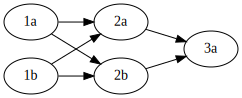

In [1]:
from graphviz import Digraph

nn = Digraph(format='svg', graph_attr={'rankdir': 'LR'}, strict=True)

nn.node('1a'); nn.node('1b')
nn.node('2a'); nn.node('2b')
nn.node('3a')

nn.edge('1a', '2a'); nn.edge('1a', '2b')
nn.edge('1b', '2a'); nn.edge('1b', '2b') 
nn.edge('2a', '3a'); nn.edge('2b', '3a')

nn

__How Many Networks?__

Take our first layer with just 2 nodes. There are 3 ways their values can be propogated with dropout: `[1a & 1b, 1a only, 1b only]`
In the same way, there are also 3 ways the values in the second layer can be propogated.

This means if we include a dropout layer after each dense layer, we are conceptually training 9 (3x3) different networks!

__For visualization purposes, here are the other 8__

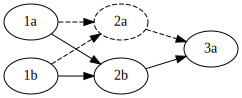

In [2]:
# Drop 2a
drop = nn.copy()
drop.node('2a', style='dashed')
drop.edge('1a', '2a', style='dashed'); drop.edge('1b', '2a', style='dashed'); drop.edge('2a', '3a', style='dashed')
drop

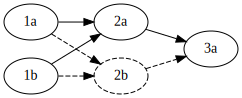

In [3]:
# Drop 2b
drop = nn.copy()
drop.node('2b', style='dashed')
drop.edge('1a', '2b', style='dashed'); drop.edge('1b', '2b', style='dashed'); drop.edge('2b', '3a', style='dashed')
drop

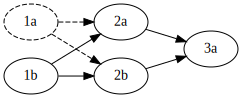

In [4]:
# Drop 1a
drop = nn.copy()
drop.node('1a', style='dashed')
drop.edge('1a', '2a', style='dashed'); drop.edge('1a', '2b', style='dashed')
drop

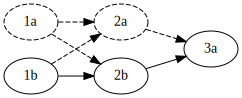

In [5]:
# Drop 1a, 2a
drop = nn.copy()
drop.node('1a', style='dashed'); drop.node('2a', style='dashed')
drop.edge('1a', '2a', style='dashed'); drop.edge('1b', '2a', style='dashed');
drop.edge('1a', '2b', style='dashed'); drop.edge('2a', '3a', style='dashed')
drop

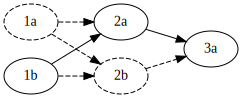

In [6]:
# Drop 1a, 2b
drop = nn.copy()
drop.node('1a', style='dashed'); drop.node('2b', style='dashed')
drop.edge('1a', '2a', style='dashed'); drop.edge('1b', '2b', style='dashed');
drop.edge('1a', '2b', style='dashed'); drop.edge('2b', '3a', style='dashed')
drop

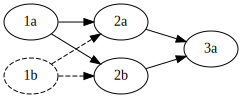

In [7]:
# Drop 1b
drop = nn.copy()
drop.node('1b', style='dashed')
drop.edge('1b', '2a', style='dashed'); drop.edge('1b', '2b', style='dashed')
drop

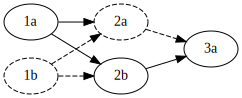

In [8]:
# Drop 1b, 2a
drop = nn.copy()
drop.node('1b', style='dashed'); drop.node('2a', style='dashed')
drop.edge('1b', '2a', style='dashed'); drop.edge('1b', '2a', style='dashed');
drop.edge('1b', '2b', style='dashed'); drop.edge('2a', '3a', style='dashed')
drop

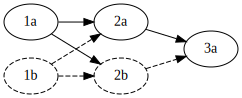

In [9]:
# Drop 1b, 2b
drop = nn.copy()
drop.node('1b', style='dashed'); drop.node('2b', style='dashed')
drop.edge('1b', '2a', style='dashed'); drop.edge('1b', '2b', style='dashed');
drop.edge('1b', '2b', style='dashed'); drop.edge('2b', '3a', style='dashed')
drop

# Dropout Node

Lets implement Dropout. Much like how we approached `Dense`, we'll start with defining a node.

The only hyperparameter we need to implement in our `Dropout` layer is `dropout_rate` - the probability that any given neuron is activated.

We'll then initialize an attribute in each node `p`, which is the `p`robability that a neuron will be activated, this is calculated as `1 - dropout_rate`.

In [10]:
# kaitorch/layers.py

class Node:

    def __init__(self, dropout_rate: float):
        self.p = 1 - dropout_rate

    def parameters(self):
        return []

Then, we generate a random float between 0 and 1 - there will be a `p` chance that this number is less than `p`, and a `1-p` chance that the number is greater than `p`. Therefore, if the number is lesser than p, we will allow the neuron to activate, if not, it will propogate 0.

In [11]:
def __call__(self, x, train):
    return x if random.random() <= self.p else 0

### Scaling Up

If we implemented this as is, we'd run into a significant problem.

Let's say in a given iteration half of our nodes are dropped out, so the number of active nodes is halved. This would result in the magnitude of values being propogated forward in the model to approximately halve too.

If each node is trained on a input magnitude `0.5x`, but is evaluated on an input magnitude `1x`, there's no way we can expect reliable results. There's 2 ways to solve this.

- __Scaling Activation__
    - During the training phase, each neuron is trained to receive a `0.5x` magnitude input due to dropout
    - During the testing phase, we __halve__ the output of every neuron, so given a `1x` magnitude input, it can produce a `0.5x` magnitude output.
    - During both phases, some kind of additional computation has to be done.
- __Inverted Dropout__
    - During the training phase, we __double__ the output of every neuron, so given a `0.5x` magnitude input, it can produce a `1x` magnitude output
    - During the testing phase, nothing needs to be done.
    
In practice, the second option is typically used because its simple to implement and doesn't require additional calculation during the testing phase.

To do this, we simply multiply active weights by `1/self.p` to preserve the magnitude of the total values being propogated forward. We also want dropout applied only during training, and make use of the full model during testing.

In [12]:
# kaitorch/layers.py

import random

def __call__(self, x, train):
    if train:
        return x * (1/self.p) if random.random() <= self.p else 0
    else:
        return x

Node.__call__ = __call__

Let's see our `Node` in action! See how with `p=0.5`, each input is either doubled or set to 0 during the training phase, but untouched during testing.

In [13]:
dropout = Node(0.5)

inputs = [random.randint(0, 10) for _ in range(10)]
print('Raw Inputs:           ', inputs)

train = [int(dropout(input, train=True)) for input in inputs]
print('Scaled Inputs (Train):', train)

test = [int(dropout(input, train=False)) for input in inputs]
print('Scaled Inputs (Test) :', test)

Raw Inputs:            [1, 5, 7, 1, 4, 1, 5, 1, 1, 1]
Scaled Inputs (Train): [2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Scaled Inputs (Test) : [1, 5, 7, 1, 4, 1, 5, 1, 1, 1]


# Dropout Layer

To organize our Dropout nodes into a layer, in addition to the `dropout_rate` hyperparameter, just as our `Dense` layer we'll also need the attributes `nins` (number of inputs), `nouts` (number of outputs), and `nodes` (list of dropout nodes). 

It's trivial to define both nins and nouts as they will be identical (each input gets its own dropout Node, so the output size of the dropout layer will be the same as the input size previous layer), but for consistency and clarity we'll add them.

In [14]:
# kaitorch/layers.py

from kaitorch.core import Module

class Dropout(Module):

    def __init__(self, dropout_rate: float=0.5):

        self.nins = None
        self.nouts = None
        self.nodes = None
        self.q = dropout_rate

        if self.q < 0 or self.q > 1:
            raise ValueError("p must be a probability")
            
    def parameters(self):
        return [p for node in self.nodes for p in node.parameters()]

    def __repr__(self):
        return f'Dropout(dropout_rate={self.q})'
    
Dropout.Node = Node

Since `nins` is entirely dependent on the output size of the previous layer, we will initialize this as `None`, and fill in this value after we define the architecture of our model and `__build__` it.

In [15]:
# kaitorch/layers.py

def __build__(self, nins):
    self.nins = nins
    self.nouts = nins
    self.nodes = [self.Node(self.q) for _ in range(self.nins)]
    
Dropout.__build__ = __build__

The last thing to do is implement the `__call__` method, which takes in the output of the previous layer as an input and calls the dropout node.

Unlike the Dense layer, we also need to pass in the `train` boolean parameter as we want [different performance lol]

In [16]:
# kaitorch/layers.py

def __call__(self, xs, train):
    outs = [n(xi, train) for n, x in zip(self.nodes, xs)]
    return unwrap(outs)

Dropout.__call__ = __call__

# Finishing our Sequential Class

We're almost done building KaiTorch! There's 2 things left on our agenda before we wrap up.

 - 1) Update our methods to incorporate the `Dropout` layer
 - 2) Build out methods similar to Keras for interfacing with the model (`fit, predict, evaluate`)

In [17]:
from kaitorch.models import Sequential

As mentioned above, unlike the Dense layer, calling the Dropout layer requires a `train` argument to specify if the current iteration is for training or not.

In [18]:
# kaitorch/layers.py

def __call__(self, x, train):
    for layer in self.layers:
        if isinstance(layer, Dropout):
            x = layer(x, train)
        else:
            x = layer(x)
    return unwrap(x)

Sequential.__call__ = __call__

Also mentioned above, the `nins` of a Dropout layer is initialized as `None` as it depends on the output size of the previous layer. So, when building our model, we need to apply a forward fill on the list of layer sizes to fill in the size of each Dropout layer.

In [19]:
# kaitorch/utils.py

def ffill(x: list):
    for i in range(1, len(x)-1):
        if x[i] is None:
            x[i] = x[i-1]
    return x

In [20]:
# kaitorch/layers.py

def build(self, input_size):

    if self.built:
        return

    self.layer_sizes.insert(0, input_size)
    self.layer_sizes = ffill(self.layer_sizes)

    for idx, layer in enumerate(self.layers):
        layer.__build__(self.layer_sizes[idx])

    self.built = True
    
Sequential.build = build

Next, we'll define a `run` method that `fit`, `predict`, and `evaluate` will all be able to use.

In [21]:
# kaitorch/layers.py

from tqdm import tqdm

def run(self, x, y=None, epoch=1, epochs=1, train=False):

    # This code just prints the progress bar - it's also the only external library used in KaiTorch
    postfix_type = 'Train' if train is True else ''

    tqdm_x = tqdm(
        x,
        ncols=160,
        desc=f"Epoch {epoch:>3}/{epochs}", 
        postfix='',
        bar_format='{l_bar}{bar:40}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}{postfix}]'
    )

    # Used to the predictions for every record in x
    y_pred = []

    # For every record in our dataset
    for x_record in tqdm_x:

        # Run a forward pass of the model
        y_pred.append(self.__call__(x_record, train=train))

        # If a y label is provided, calculate the loss value
        if y:
            run_loss = self.loss(y[:len(y_pred)], y_pred)
            tqdm_x.set_postfix_str(f"{postfix_type} Loss: {run_loss.data:.4f}")
        # Otherwise, don't
        else:
            run_loss = None
            tqdm_x.set_postfix_str(f"{postfix_type}")

    # This is the training loop introduced in Notebook 4
    if train:
        self.zero_grad()
        run_loss.backward()
        self.step()

    return y_pred, run_loss

Sequential.run = run

Almost done! We just need to implement fit, predict, and evaluate, which have some overlapping steps. This is a summary of what each one needs to do:


|  | fit() | predict() | evaluate() |
| --- | --- | --- | --- |
| __Calculate Loss__ | Yes | No | Yes|
| __Output Predictions__ | No | Yes | No |
| __Train Model__ | Yes | No | No |

<br><center><i>i just learnt you could make tables like this with markdown pretty cool right</i></center>

So going row by row:

- __Calculate Loss__ is returned by `run()`, and we need to initialize `history` to store the loss
- __Output Predictions__ is also returned by `run()`, and we need to do some processing to make sure the output is in the format we want
- __Train Model__ just requires us to pass `train=True` to `run()`, as well as the current `epoch` and number of `epochs` for printing and training

All 3 functions will also need to apply `wrap` to our input to make sure it is an iterable, and will `build` the model if it hasn't been built yet.

In [22]:
# kaitorch/models.py

def fit(self, x, y, epochs=1):

    x = wrap(x)
    self.build(len(x[0]))

    history = {'loss': []}

    for epoch in range(1, epochs+1):

        y_pred, run_loss = self.run(x, y, epoch, epochs, train=True)
        history['loss'].append(run_loss.data)

    return history

def evaluate(self, x, y):

    x = wrap(x)
    self.build(len(x[0]))
    
    history = {'loss': []}

    y_pred, run_loss = self.run(x, y)
    history['loss'].append(run_loss.data)

    return history

def predict(self, x, as_scalar=False):

    x = wrap(x)
    self.build(len(x[0]))

    y_pred, run_loss = self.run(x)

    # as_scalar argument for user to specify if the output should be `Scalar` or numeric
    if as_scalar:
        return y_pred
    else:
        # if output of each run is a single Scalar | eg. binary classification
        if isinstance(y_pred[0], Scalar):
            return [y.data for y in y_pred]
        # if output of each run is a list of Scalars | eg. multi-class classification
        elif isinstance(y_pred[0][0], Scalar):
            return [[y.data for y in row] for row in y_pred]

Sequential.fit = fit
Sequential.evaluate = evaluate
Sequential.predict = predict

# KaiTorch is Complete! 🥳

Thanks for sticking around and congrats for making it to the end. I hope this was helpful :)

__Let's train some models__ $\Rightarrow$
